<img src="https://www.unir.net/wp-content/uploads/2019/11/Unir_2021_logo.svg" width="240" height="240" align="right"/>

<center><h1>Trabajo Final de Estudios</header1></center>
<center><h1>Predicción de la evolución de criptomonedas en Binance mediante IA</header1></center>
<center><h1>Clasificación entre BTC, ORO, EUR, VIX, Fed Fund Rate, Búsquedas en Google y Sentimiento del mercado </header1></center>

Trabajo fin de estudio presentado por: **Jorge Manuel Ibáñez Vázquez** <br>
Tipo de trabajo:                       Piloto experimental <br>
Director:                              Luis Guadalupe Macías Trejo <br>
Fecha:                                 17/04/2025

## Resumen
El modelo de clasificación tuvo como objetivo predecir si el precio del Bitcoin (BTC) subiría o bajaría en el día siguiente, lo que requirió un análisis de datos diarios multivariados.
- Fuentes de Datos: Se recopilaron datos históricos diarios de diversas fuentes, abarcando un amplio espectro de variables que podrían influir en el precio de BTC:
    - Precios de Activos Financieros: Los datos de precios de cierre para BTC/USD, ORO/USD (futuros de oro GC=F) y EUR/USD (EURUSD=X) se descargaron desde Yahoo Finance (yfinance) para un periodo desde 2016 hasta 2025.
    - Índice de Volatilidad (VIX): Este índice, que mide la expectativa de volatilidad del mercado, también se obtuvo de Yahoo Finance (^VIX) para el mismo periodo.
    - Tasa de Interés de la Reserva Federal (Fed Funds Rate): Los datos diarios de la tasa de referencia de EE. UU. (DFF) se obtuvieron de la API de Fred (fredapi).
    - Volumen de Búsquedas en Google Trends: El interés de búsqueda por la palabra "Bitcoin" se obtuvo a través de pytrends, registrando valores de 0 a 100 en el período desde 2016 hasta 2025.
    - Sentimiento del Mercado: Un índice de "Fear & Greed" se descargó de alternative.me/fng/ para capturar el sentimiento general del mercado de criptomonedas.


## Instalación de librerias necesarias

In [2]:
# Librerias que son necesarias instalar
!pip install missingno -q

In [2]:
!pip install yfinance pandas numpy matplotlib scikit-learn -q

In [3]:
!pip install --upgrade yfinance -q

In [4]:
!pip install pandas_datareader -q

In [5]:
## Necesario para la tasa de interés de EE.UU. fijada por la Reserva Federal
!pip install fredapi -q

In [6]:
# Para ver las tendencias de búsqueda en Google
!pip install --upgrade pytrends -q

In [7]:
# Para el modelado de redes neuronales
!pip install importlib-resources tqdm -q

!pip install tensorflow -q

In [8]:
# Librería de Binance
!pip install python-binance -q

## Importación de librerias necesarias

In [9]:
# Importar Pandas
import pandas as pd

# Importar Scikit-learn
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Importar TensorFlow
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Importar Matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Importar missingno
import missingno as msno

# Importar Numpy
import numpy as np

import datetime as dt
from datetime import datetime, timedelta
import requests

# Yahoo Finance
import yfinance as yf

# Para mostrar tablas por pantalla
from IPython.display import display

# Para la API del Federal Reserve Economic Data
from fredapi import Fred

# Para Google Trends
from pytrends.request import TrendReq
import time
import os

import joblib

## Cargar los valores a comparar: BTC/USD, ORO/USD y EUR/USD

### Descargar datos del BTC/USD

⚠️ Error al cargar CSV: [Errno 2] No such file or directory: 'btc_dataset.csv'
⬇️ Descargando datos desde...


C:\Users\jorge\AppData\Local\Temp\ipykernel_16920\1875732411.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_btc = yf.download("BTC-USD", start, end, interval= intervalo)
[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open    Volume
Ticker         BTC-USD     BTC-USD     BTC-USD     BTC-USD   BTC-USD
Date                                                                
2016-01-01  434.334015  436.246002  427.515015  430.721008  36278900
2016-01-02  433.437988  436.062012  431.869995  434.622009  30096600
2016-01-03  430.010986  433.743011  424.705994  433.578003  39633800
2016-01-04  433.091003  434.516998  429.084015  430.061005  38477500
2016-01-05  431.959991  434.182007  429.675995  433.069000  34522600


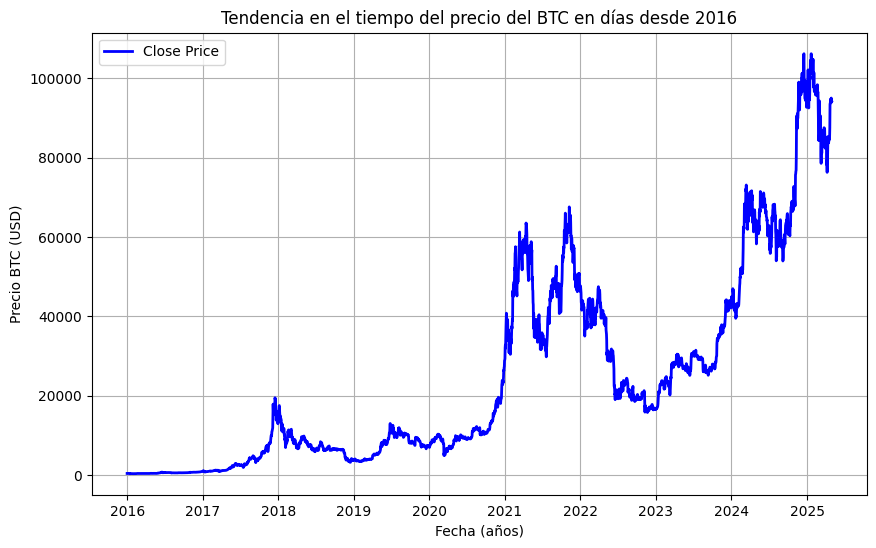

In [10]:
try:
    # Intentar cargar desde CSV
    data_btc = pd.read_csv("btc_dataset.csv")
    print("✅ Datos de cargados desde CSV.")
    # Asegurar de que la columna 'Close' sea numérica y eliminar valores NaN
    data_btc['Close'] = pd.to_numeric(data_btc['Close'], errors='coerce')  # Convierte a numérico, los errores se convierten en NaN
    data_btc = data_btc.dropna(subset=['Close'])  # Elimina filas donde la columna 'Close' es NaN
except Exception as e:
    print(f"⚠️ Error al cargar CSV: {e}")
    print("⬇️ Descargando datos desde...")
    # Fechas entre las que realizar la descarga de datos
    start = dt.datetime(2016, 1, 1)
    end = dt.datetime(2025, 5, 1)
    
    # Intervalo 1m, 2m, 5m, 15m, 30, 60m 90m, 1d, 5d, 1wk, 1mo, 3mo
    # De 1m a 90m se usa: period="5d", interval="5m"
    # de 1d a 3mo se usa: start, end, interval= "1d"
    intervalo = "1d"
    
    # Descargar datos históricos del BTC-USD
    data_btc = yf.download("BTC-USD", start, end, interval= intervalo)

if 'Unnamed: 0' in data_btc.columns:
    data_btc = data_btc.drop(columns=['Unnamed: 0'])
print(data_btc.head())

data_original = data_btc.copy()
data_BTC = data_btc.copy()

# Plotting
plt.figure(figsize=(10, 6))
#plt.plot(data_btc['Close'], label='Precio BTC-USD', color='blue')
plt.plot(data_btc.index, data_btc['Close'], label = 'Close Price', color = 'blue', linewidth = 2)
plt.title('Tendencia en el tiempo del precio del BTC en días desde 2016')
plt.xlabel('Fecha (años)')
plt.ylabel('Precio BTC (USD)')
plt.legend()
plt.grid(True)
plt.show()

### Descargar datos del ORO/USD

⚠️ Error al cargar CSV: [Errno 2] No such file or directory: 'oro_dataset.csv'
⬇️ Descargando datos desde...


C:\Users\jorge\AppData\Local\Temp\ipykernel_16920\2214583394.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_oro = yf.download("GC=F", start=start, end=end, interval=intervalo)
[*********************100%***********************]  1 of 1 completed


Price             Close         High          Low         Open Volume
Ticker             GC=F         GC=F         GC=F         GC=F   GC=F
Date                                                                 
2016-01-04  1075.099976  1082.500000  1063.199951  1063.400024    143
2016-01-05  1078.400024  1081.500000  1075.300049  1075.599976     82
2016-01-06  1091.900024  1093.699951  1081.599976  1081.599976     52
2016-01-07  1107.699951  1109.400024  1091.599976  1091.599976    122
2016-01-08  1097.800049  1111.099976  1093.000000  1111.099976     98


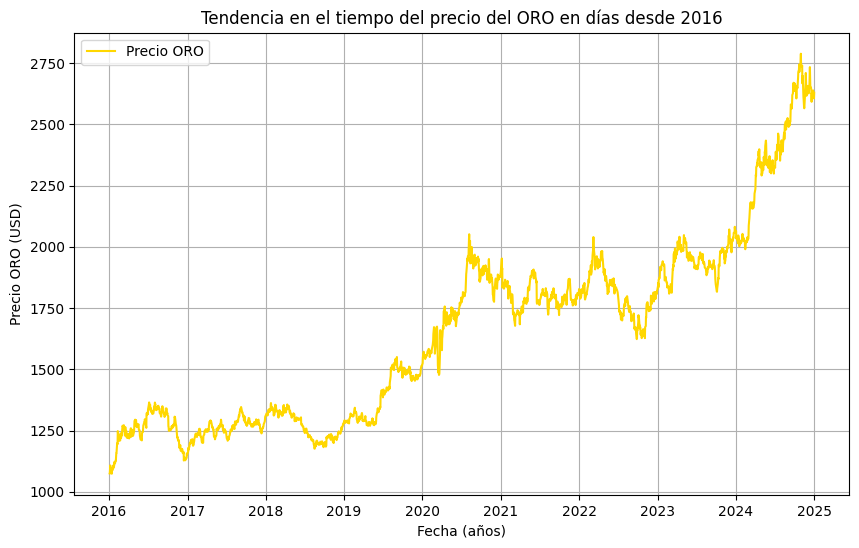

In [11]:
try:
    # Intentar cargar desde CSV
    data_oro = pd.read_csv("oro_dataset.csv")
    print("✅ Datos de cargados desde CSV.")
    # Asegurar de que la columna 'Close' sea numérica y eliminar valores NaN
    data_oro['Close'] = pd.to_numeric(data_oro['Close'], errors='coerce')  # Convierte a numérico, los errores se convierten en NaN
    data_oro = data_oro.dropna(subset=['Close'])  # Elimina filas donde la columna 'Close' es NaN
except Exception as e:
    print(f"⚠️ Error al cargar CSV: {e}")
    print("⬇️ Descargando datos desde...")
    # Fechas entre las que realizar la descarga de datos
    start = dt.datetime(2016, 1, 1)
    end = dt.datetime(2025, 1, 1)
    
    # Intervalo 1m, 2m, 5m, 15m, 30, 60m 90m, 1d, 5d, 1wk, 1mo, 3mo
    # De 1m a 90m se usa: period="5d", interval="5m"
    # de 1d a 3mo se usa: start, end, interval= "1d"
    intervalo = "1d"
    
    # Descargar datos históricos del oro (Gold Futures)
    data_oro = yf.download("GC=F", start=start, end=end, interval=intervalo)


if 'Unnamed: 0' in data_oro.columns:
    data_oro = data_oro.drop(columns=['Unnamed: 0'])
print(data_oro.head())

data_oro.index.name = 'Date' # Renombrar el índice a 'Date'

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(data_oro['Close'], label='Precio ORO', color='gold')
plt.title('Tendencia en el tiempo del precio del ORO en días desde 2016')
plt.xlabel('Fecha (años)')
plt.ylabel('Precio ORO (USD)')
plt.legend()
plt.grid(True)
plt.show()

### Descargar datos del EUR/USD

⚠️ Error al cargar CSV: [Errno 2] No such file or directory: 'eur_dataset.csv'
⬇️ Descargando datos desde...


C:\Users\jorge\AppData\Local\Temp\ipykernel_16920\490620210.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_eur = yf.download("EURUSD=X", start=start, end=end, interval=intervalo)
[*********************100%***********************]  1 of 1 completed


Price          Close      High       Low      Open   Volume
Ticker      EURUSD=X  EURUSD=X  EURUSD=X  EURUSD=X EURUSD=X
Date                                                       
2016-01-01  1.085906  1.086697  1.085906  1.085906        0
2016-01-04  1.085399  1.094600  1.080600  1.085505        0
2016-01-05  1.082755  1.084105  1.071201  1.082603        0
2016-01-06  1.075199  1.077203  1.072200  1.075199        0
2016-01-07  1.077900  1.087600  1.077400  1.077795        0


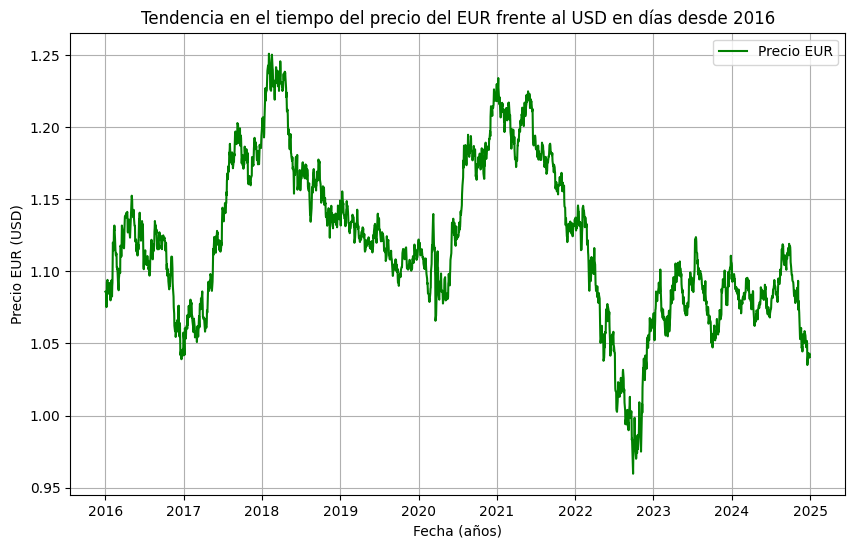

In [12]:
try:
    # Intentar cargar desde CSV
    data_eur = pd.read_csv("eur_dataset.csv")
    print("✅ Datos de cargados desde CSV.")
    # Asegurar de que la columna 'Close' sea numérica y eliminar valores NaN
    data_eur['Close'] = pd.to_numeric(data_eur['Close'], errors='coerce')  # Convierte a numérico, los errores se convierten en NaN
    data_eur = data_eur.dropna(subset=['Close'])  # Elimina filas donde la columna 'Close' es NaN
except Exception as e:
    print(f"⚠️ Error al cargar CSV: {e}")
    print("⬇️ Descargando datos desde...")
    # Fechas entre las que realizar la descarga de datos
    start = dt.datetime(2016, 1, 1)
    end = dt.datetime(2025, 1, 1)
    
    # Intervalo 1m, 2m, 5m, 15m, 30, 60m 90m, 1d, 5d, 1wk, 1mo, 3mo
    # De 1m a 90m se usa: period="5d", interval="5m"
    # de 1d a 3mo se usa: start, end, interval= "1d"
    intervalo = "1d"
    
    # Descargar datos históricos del EURO frente al DOLAR
    data_eur = yf.download("EURUSD=X", start=start, end=end, interval=intervalo)

if 'Unnamed: 0' in data_eur.columns:
    data_eur = data_eur.drop(columns=['Unnamed: 0'])
print(data_eur.head())

data_eur.index.name = 'Date' # Renombrar el índice a 'Date'

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(data_eur['Close'], label='Precio EUR', color='green')
plt.title('Tendencia en el tiempo del precio del EUR frente al USD en días desde 2016')
plt.xlabel('Fecha (años)')
plt.ylabel('Precio EUR (USD)')
plt.legend()
plt.grid(True)
plt.show()

### Descargar datos del VIX (Índice de Volatibilidad)

⚠️ Error al cargar CSV: [Errno 2] No such file or directory: 'vix_dataset.csv'
⬇️ Descargando datos desde...


C:\Users\jorge\AppData\Local\Temp\ipykernel_16920\1211644930.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_vix = yf.download("^VIX", start=start, end=end, interval=intervalo)
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open Volume
Ticker           ^VIX       ^VIX       ^VIX       ^VIX   ^VIX
Date                                                         
2016-01-04  20.700001  23.360001  20.670000  22.480000      0
2016-01-05  19.340000  21.059999  19.250000  20.750000      0
2016-01-06  20.590000  21.860001  19.799999  21.670000      0
2016-01-07  24.990000  25.860001  22.400000  23.219999      0
2016-01-08  27.010000  27.080000  22.480000  22.959999      0


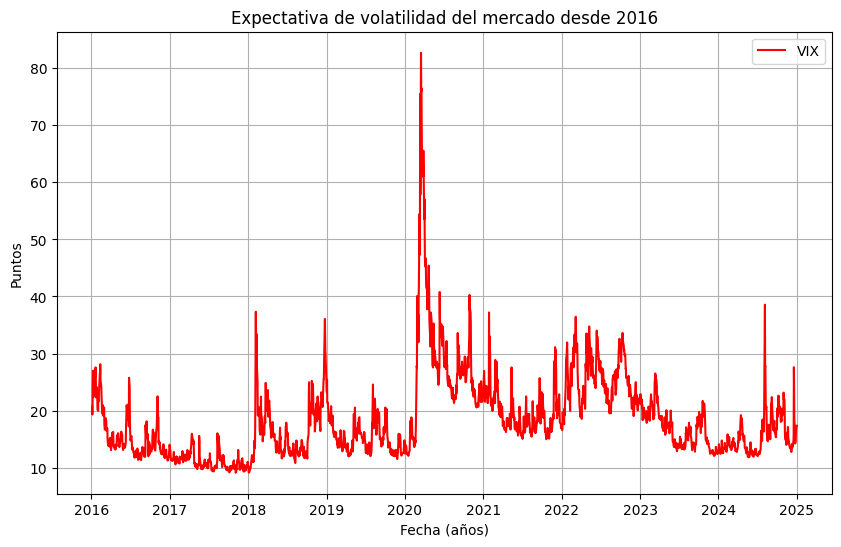

In [13]:
try:
    # Intentar cargar desde CSV
    data_vix = pd.read_csv("vix_dataset.csv")
    print("✅ Datos de cargados desde CSV.")
    # Asegurar de que la columna 'Close' sea numérica y eliminar valores NaN
    data_vix['Close'] = pd.to_numeric(data_vix['Close'], errors='coerce')  # Convierte a numérico, los errores se convierten en NaN
    data_vix = data_vix.dropna(subset=['Close'])  # Elimina filas donde la columna 'Close' es NaN
except Exception as e:
    print(f"⚠️ Error al cargar CSV: {e}")
    print("⬇️ Descargando datos desde...")
    # Fechas entre las que realizar la descarga de datos
    start = dt.datetime(2016, 1, 1)
    end = dt.datetime(2025, 1, 1)
    
    # Intervalo 1m, 2m, 5m, 15m, 30, 60m 90m, 1d, 5d, 1wk, 1mo, 3mo
    # De 1m a 90m se usa: period="5d", interval="5m"
    # de 1d a 3mo se usa: start, end, interval= "1d"
    intervalo = "1d"
    
    data_vix = yf.download("^VIX", start=start, end=end, interval=intervalo)

if 'Unnamed: 0' in data_vix.columns:
    data_vix = data_vix.drop(columns=['Unnamed: 0'])
print(data_vix.head())

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(data_vix['Close'], label='VIX', color='red')
plt.title('Expectativa de volatilidad del mercado desde 2016')
plt.xlabel('Fecha (años)')
plt.ylabel('Puntos')
plt.legend()
plt.grid(True)
plt.show()


### Descargar datos de la tasa de Interés (Fed Funds Rate)

⚠️ Error al cargar CSV: [Errno 2] No such file or directory: 'fed_rate_dataset1.csv'
⬇️ Descargando datos desde la API de FRED...
✅ Datos de la tasa Fed Funds descargados.
            FedRate
2016-01-01     0.20
2016-01-02     0.20
2016-01-03     0.20
2016-01-04     0.36
2016-01-05     0.36


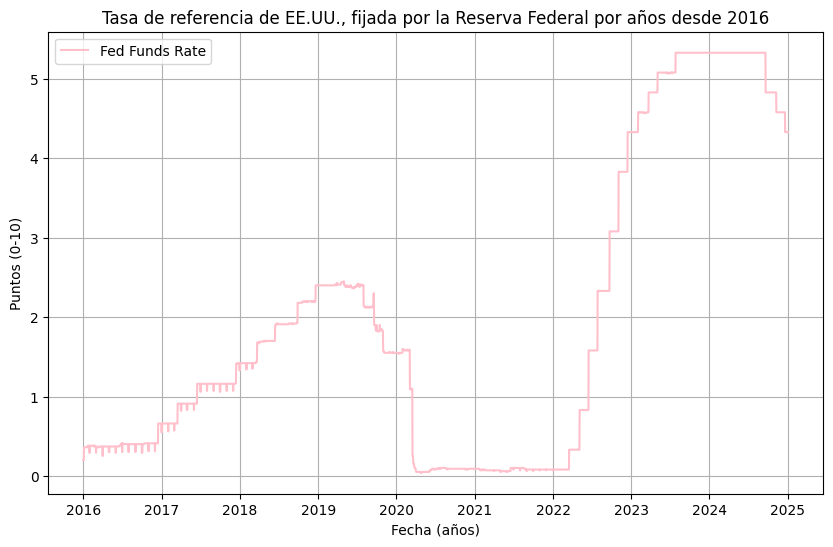

In [14]:
try:
    # Intentar cargar desde CSV
    data_fed_rate = pd.read_csv("fed_rate_dataset1.csv")
    print("✅ Datos cargados desde CSV.")
    
except Exception as e:
    print(f"⚠️ Error al cargar CSV: {e}")
    print("⬇️ Descargando datos desde la API de FRED...")
    
    # API de FRED (requiere una clave de API)
    fred = Fred(api_key='1e8e5876687c6a1c5b0d6850a3793f34')
    
    # Fechas para los datos
    start = '2016-01-01'
    end = '2025-01-01'
    
    # Obtener la tasa de interés diaria (Fed Funds Rate) con la serie DFF
    fed_rate_daily = fred.get_series('DFF', start_date=start, end_date=end)
    fed_rate_daily = fed_rate_daily.to_frame(name='FedRate')

    # Filtrar las fechas (si es necesario)
    data_fed_rate = fed_rate_daily[start:end]
    
    print("✅ Datos de la tasa Fed Funds descargados.")

# Ver los primeros registros
if 'Unnamed: 0' in data_fed_rate.columns:
    data_fed_rate = data_fed_rate.drop(columns=['Unnamed: 0'])
print(data_fed_rate.head())

data_fed_rate.index.name = 'Date' # Renombrar el índice a 'Date'

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(data_fed_rate['FedRate'], label='Fed Funds Rate', color='pink')
plt.title('Tasa de referencia de EE.UU., fijada por la Reserva Federal por años desde 2016')
plt.xlabel('Fecha (años)')
plt.ylabel('Puntos (0-10)')
plt.legend()
plt.grid(True)
plt.show()

### Descargar datos del Volumen de búsqueda en Google Trends

⚠️ Error al cargar CSV: [Errno 2] No such file or directory: 'google_trends_dataset.csv'
⬇️ Descargando datos desde Google Trends...

⬇️ Descargando: 2016-01-01 2016-03-31
✅ Descarga completada: 2016-01-01 2016-03-31

⬇️ Descargando: 2016-03-31 2016-06-29
✅ Descarga completada: 2016-03-31 2016-06-29

⬇️ Descargando: 2016-06-29 2016-09-27
✅ Descarga completada: 2016-06-29 2016-09-27

⬇️ Descargando: 2016-09-27 2016-12-26
✅ Descarga completada: 2016-09-27 2016-12-26

⬇️ Descargando: 2016-12-26 2017-03-26
✅ Descarga completada: 2016-12-26 2017-03-26

⬇️ Descargando: 2017-03-26 2017-06-24
✅ Descarga completada: 2017-03-26 2017-06-24

⬇️ Descargando: 2017-06-24 2017-09-22
✅ Descarga completada: 2017-06-24 2017-09-22

⬇️ Descargando: 2017-09-22 2017-12-21
✅ Descarga completada: 2017-09-22 2017-12-21

⬇️ Descargando: 2017-12-21 2018-03-21
✅ Descarga completada: 2017-12-21 2018-03-21

⬇️ Descargando: 2018-03-21 2018-06-19
✅ Descarga completada: 2018-03-21 2018-06-19

⬇️ Descargando: 2018-06-19

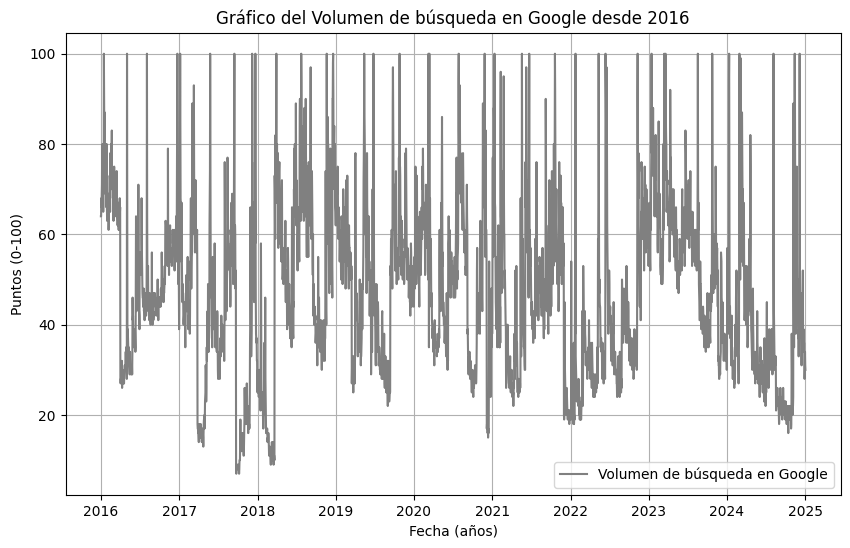

In [15]:
try:
    # Intentar cargar desde CSV
    data_google_trends = pd.read_csv("google_trends_dataset.csv")
    print("✅ Datos de Google Trends cargados desde CSV.")

except Exception as e:
    print(f"⚠️ Error al cargar CSV: {e}")
    print("⬇️ Descargando datos desde Google Trends...")

    pytrends = TrendReq(hl='en-US', tz=360)

    kw = 'Bitcoin'
    #kw = ['Bitcoin', 'btc', 'bitcoin price', 'crypto']
    start_date = datetime(2016, 1, 1)
    end_date = datetime(2025, 1, 1)

    delta = timedelta(days=90)
    current = start_date
    frames = []

    while current < end_date:
        next_date = min(current + delta, end_date)
        timeframe = f"{current.strftime('%Y-%m-%d')} {next_date.strftime('%Y-%m-%d')}"
        print(f"\n⬇️ Descargando: {timeframe}")
        
        # Backoff exponencial
        success = False
        wait_time = 60  # tiempo inicial de espera en segundos

        while not success:
            try:
                pytrends.build_payload([kw], timeframe=timeframe)
                data = pytrends.interest_over_time()
                if not data.empty:
                    frames.append(data[[kw]])
                print(f"✅ Descarga completada: {timeframe}")
                success = True  # salimos del bucle de reintento
            except Exception as e:
                print(f"⚠️ Error en {timeframe}: {e}")
                print(f"⏳ Esperando {wait_time} segundos antes de reintentar...")
                time.sleep(wait_time)
                wait_time *= 2  # duplicamos el tiempo de espera para el próximo intento
        
        current = next_date
        time.sleep(5)  # espera normal entre bloques si todo salió bien


    # Unimos y limpiamos
    result = pd.concat(frames)
    data_google_trends = result[~result.index.duplicated(keep='first')]
    data_google_trends.index.name = "date"

if 'Unnamed: 0' in data_google_trends.columns:
    data_google_trends = data_google_trends.drop(columns=['Unnamed: 0'])
print(data_google_trends.head())

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(data_google_trends['Bitcoin'], label='Volumen de búsqueda en Google', color='grey')
plt.title('Gráfico del Volumen de búsqueda en Google desde 2016')
plt.xlabel('Fecha (años)')
plt.ylabel('Puntos (0-100)')
plt.legend()
plt.grid(True)
plt.show()

### Descargar datos del Sentimiento del mercado

⚠️ Error al cargar CSV: [Errno 2] No such file or directory: 'fear_greed_dataset.csv'
⬇️ Descargando datos desde...
            FearGreedIndex value_classification time_until_update
timestamp                                                        
2018-02-01              30                 Fear               NaN
2018-02-02              15         Extreme Fear               NaN
2018-02-03              40                 Fear               NaN
2018-02-04              24         Extreme Fear               NaN
2018-02-05              11         Extreme Fear               NaN


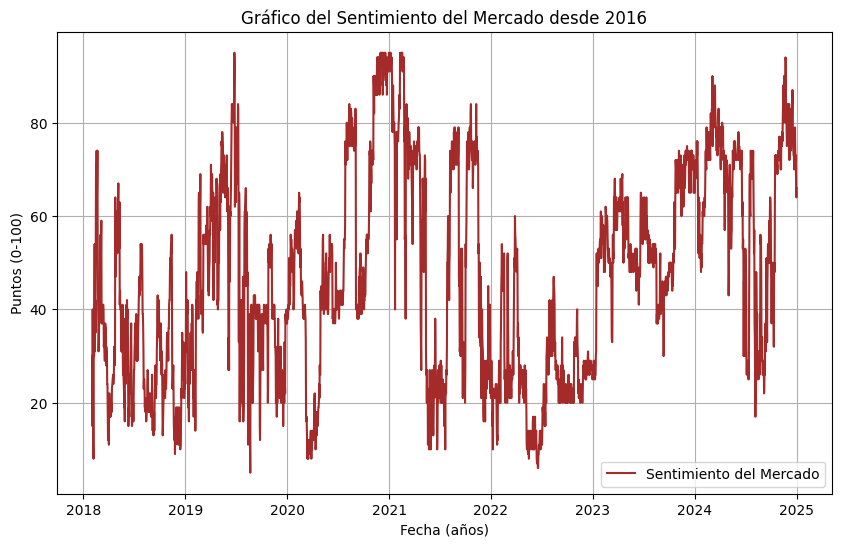

In [16]:
try:
    # Intentar cargar desde CSV
    data_fear_greed = pd.read_csv("fear_greed_dataset.csv")
    print("✅ Datos de cargados desde CSV.")

except Exception as e:
    print(f"⚠️ Error al cargar CSV: {e}")
    print("⬇️ Descargando datos desde...")
    start = '2016-01-01'
    end = '2025-01-01'
    
    url = 'https://api.alternative.me/fng/?limit=0&format=json'
    response = requests.get(url)
    data = response.json()
    
    # Parse data
    fear_greed = pd.DataFrame(data['data'])
    fear_greed['timestamp'] = pd.to_datetime(fear_greed['timestamp'].astype(int), unit='s')
    fear_greed.set_index('timestamp', inplace=True)
    fear_greed['value'] = fear_greed['value'].astype(int)
    fear_greed = fear_greed.rename(columns={'value': 'FearGreedIndex'})
    fear_greed = fear_greed.sort_index()
    fear_greed.index = pd.to_datetime(fear_greed.index)
    data_fear_greed = fear_greed[start : end]

if 'Unnamed: 0' in data_fear_greed.columns:
    data_fear_greed = data_fear_greed.drop(columns=['Unnamed: 0'])
print(data_fear_greed.head())

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(data_fear_greed['FearGreedIndex'], label='Sentimiento del Mercado', color='brown')
plt.title('Gráfico del Sentimiento del Mercado desde 2016')
plt.xlabel('Fecha (años)')
plt.ylabel('Puntos (0-100)')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Guardar los datos descargados en CSV por si hicieran falta en otro momento
data_btc.to_csv('btc_dataset.csv', index=True)
data_oro.to_csv('oro_dataset.csv', index=True)
data_eur.to_csv('eur_dataset.csv', index=True)
data_vix.to_csv('vix_dataset.csv', index=True)
data_fed_rate.to_csv('fed_rate_dataset.csv', index=True)
data_google_trends.to_csv('google_trends_dataset.csv', index=True)
data_fear_greed.to_csv('fear_greed_dataset.csv', index=True)

## Caracterización de los dataset

Se incluye una descripción de los datos que son:

>- Como índice se usa para todos los dataframes la columna ['Date'] que representa:
>      * 'Date': fecha o periodo al que corresponden los valores obtenidos de cada registro.

>- Los dataframe que hacen referencia al **BTC, ORO, EUR y VIX** tienen 5 clases, que son las columnas: ['Close', 'High', 'Low', 'Open', 'Volume'], que representan:
>      * 'Close': precio de cierre al fin de un periodo determinado. Tipo float64.
>      * 'High': el precio más alto al fin de un periodo determinado. Tipo float64.
>      * 'Low': el precio más bajo al fin de un periodo determinado. Tipo float64.
>      * 'Open': precio de apertura al inicio de un periodo determinado. Tipo float64.
>      * 'Volume': volumen de transacciones, que indican cuantas unidades del valor se negociaron en un periodo determinado. Tipo int64.

>- El dataframe que hacen referencia al **Fed Fund Rate (tasa de interés)** solo tiene una columna: ['FedRate'], que representan:
>      * 'FedRate': representa el valor de la tasa de interés. Valores de 0 a 6. Tipo int64.

>- El dataframe que hacen referencia al **Búsqueda en Google** solo tiene una columna: ['Bitcoin'], que representan:
>      * 'Bitcoin': valor en que la palabra 'Bitcoin' está siento buscada en Google. Valores de 0 a 100. Tipo int64.

>- El dataframe que hacen referencia al **Sentimiento del Mercado** tiene dos columnas: ['FearGreedIndex', 'value_classification'], que representan:
>      * 'FearGreedIndex': representa el sentimiento del mercado. Valores del 0 a 100.  Tipo int64.
>      * 'value_classification': representa el sentimiento del mercado. Tipo object.

>- Número de instancias en total:
>    * BTC/USD 3288 registros
>    * ORO/USD: 2261 registros
>    * EUR/USD: 2345 registros
>    * VIX: 2264 registros
>    * Fed Fund Rate (tasa de interés): 3289 registros
>    * Búsquedas en Google: 3289 registros
>    * Sentimiento del mercado: 2523 registros

In [18]:
for df_name in ['data_btc', 'data_oro', 'data_eur', 'data_vix', 'data_fed_rate', 'data_google_trends', 'data_fear_greed']:
    df = globals()[df_name]  # Accede al DataFrame desde el nombre en string
    print(f"{df_name}: {len(df)} registros | Columnas: {df.columns.tolist()}")

data_btc: 3408 registros | Columnas: [('Close', 'BTC-USD'), ('High', 'BTC-USD'), ('Low', 'BTC-USD'), ('Open', 'BTC-USD'), ('Volume', 'BTC-USD')]
data_oro: 2261 registros | Columnas: [('Close', 'GC=F'), ('High', 'GC=F'), ('Low', 'GC=F'), ('Open', 'GC=F'), ('Volume', 'GC=F')]
data_eur: 2345 registros | Columnas: [('Close', 'EURUSD=X'), ('High', 'EURUSD=X'), ('Low', 'EURUSD=X'), ('Open', 'EURUSD=X'), ('Volume', 'EURUSD=X')]
data_vix: 2264 registros | Columnas: [('Close', '^VIX'), ('High', '^VIX'), ('Low', '^VIX'), ('Open', '^VIX'), ('Volume', '^VIX')]
data_fed_rate: 3289 registros | Columnas: ['FedRate']
data_google_trends: 3289 registros | Columnas: ['Bitcoin']
data_fear_greed: 2523 registros | Columnas: ['FearGreedIndex', 'value_classification', 'time_until_update']


In [19]:
print("BTC:")
print(data_btc.dtypes)
print("\nOro:")
print(data_oro.dtypes)
print("\nEUR:")
print(data_eur.dtypes)
print("\nVIX:")
print(data_vix.dtypes)
print("\nFED RATE:")
print(data_fed_rate.dtypes)
print("\nGOOGLE TRENDS:")
print(data_google_trends.dtypes)
print("\nFEAR GREED:")
print(data_fear_greed.dtypes)

BTC:
Price   Ticker 
Close   BTC-USD    float64
High    BTC-USD    float64
Low     BTC-USD    float64
Open    BTC-USD    float64
Volume  BTC-USD      int64
dtype: object

Oro:
Price   Ticker
Close   GC=F      float64
High    GC=F      float64
Low     GC=F      float64
Open    GC=F      float64
Volume  GC=F        int64
dtype: object

EUR:
Price   Ticker  
Close   EURUSD=X    float64
High    EURUSD=X    float64
Low     EURUSD=X    float64
Open    EURUSD=X    float64
Volume  EURUSD=X      int64
dtype: object

VIX:
Price   Ticker
Close   ^VIX      float64
High    ^VIX      float64
Low     ^VIX      float64
Open    ^VIX      float64
Volume  ^VIX        int64
dtype: object

FED RATE:
FedRate    float64
dtype: object

GOOGLE TRENDS:
Bitcoin    int64
dtype: object

FEAR GREED:
FearGreedIndex           int64
value_classification    object
time_until_update       object
dtype: object


## Preprocesamiento del dataset. Transformaciones previas necesarias para la modelación

### Hay que eliminar los multi-índices para trabajar con los dataframes de forma correcta

In [20]:
def simplificar_multiindice(df, nombre_indice_fecha='Date'):
    # Paso 1: Eliminar el nivel 'Ticker' del MultiIndex de columnas
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.droplevel('Ticker')
    
    # Paso 2: Eliminar el nombre del nivel de columnas
    df.columns.name = None
    
    # Paso 3: Renombrar el índice de fechas
    if 'Price' in df.columns:
        df['Price'] = pd.to_datetime(df['Price'])  # Asegurarse de que 'date' esté en formato datetime
        df = df.set_index('Price')
        df.index.name = nombre_indice_fecha
    elif 'Date' not in df.columns:
        df.index.name = nombre_indice_fecha
    return df

# Aplicar la función al BTC
data_btc_simplificado = simplificar_multiindice(data_btc)
print(data_btc_simplificado.head())

# Aplicar la función al ORO
data_oro_simplificado = simplificar_multiindice(data_oro)
print(data_oro_simplificado.head())

# Aplicar la función al EUR
data_eur_simplificado = simplificar_multiindice(data_eur)
print(data_eur_simplificado.head())

# Aplicar la función al VIX
data_vix_simplificado = simplificar_multiindice(data_vix)
print(data_vix_simplificado.head())

                 Close        High         Low        Open    Volume
Date                                                                
2016-01-01  434.334015  436.246002  427.515015  430.721008  36278900
2016-01-02  433.437988  436.062012  431.869995  434.622009  30096600
2016-01-03  430.010986  433.743011  424.705994  433.578003  39633800
2016-01-04  433.091003  434.516998  429.084015  430.061005  38477500
2016-01-05  431.959991  434.182007  429.675995  433.069000  34522600
                  Close         High          Low         Open  Volume
Date                                                                  
2016-01-04  1075.099976  1082.500000  1063.199951  1063.400024     143
2016-01-05  1078.400024  1081.500000  1075.300049  1075.599976      82
2016-01-06  1091.900024  1093.699951  1081.599976  1081.599976      52
2016-01-07  1107.699951  1109.400024  1091.599976  1091.599976     122
2016-01-08  1097.800049  1111.099976  1093.000000  1111.099976      98
               Close

In [21]:
if 'date' in data_google_trends.columns:
    data_google_trends['date'] = pd.to_datetime(data_google_trends['date']) # Asegurarse de que 'date' esté en formato datetime
    data_google_trends = data_google_trends.set_index('date')
    data_google_trends.index.name = 'Date'
elif 'Date' not in df.columns:
    data_google_trends.index = pd.to_datetime(data_google_trends.index, dayfirst=True)
    data_google_trends.index.name = 'Date'
print(data_google_trends.head())


# Convertir la columna de 'date' en el índice y renombrarla a 'Date'
if 'date' in data_fed_rate.columns:
    data_fed_rate['date'] = pd.to_datetime(data_fed_rate['date'])  # Asegurarse de que 'date' esté en formato datetime
    data_fed_rate = data_fed_rate.set_index('date')
    data_fed_rate.index.name = 'Date'
elif 'Date' not in df.columns:
    data_fed_rate.index = pd.to_datetime(data_fed_rate.index, dayfirst=True)
    data_fed_rate.index.name = 'Date'
print(data_fed_rate.head())


# Convertir la columna de 'timestamp' en el índice y renombrarla a 'Date'
if 'timestamp' in data_fear_greed.columns:
    data_fear_greed['timestamp'] = pd.to_datetime(data_fear_greed['timestamp'])  # Asegurarse de que 'date' esté en formato datetime
    data_fear_greed = data_fear_greed.set_index('timestamp')
    data_fear_greed.index.name = 'Date'
elif 'Date' not in df.columns:
    data_fear_greed.index = pd.to_datetime(data_fear_greed.index, dayfirst=True)
    data_fear_greed.index.name = 'Date'
print(data_fear_greed.head())

            Bitcoin
Date               
2016-01-01       64
2016-01-02       64
2016-01-03       68
2016-01-04       66
2016-01-05       69
            FedRate
Date               
2016-01-01     0.20
2016-01-02     0.20
2016-01-03     0.20
2016-01-04     0.36
2016-01-05     0.36
            FearGreedIndex value_classification time_until_update
Date                                                             
2018-02-01              30                 Fear               NaN
2018-02-02              15         Extreme Fear               NaN
2018-02-03              40                 Fear               NaN
2018-02-04              24         Extreme Fear               NaN
2018-02-05              11         Extreme Fear               NaN


### Se observa que el campo Date tiene distinta cantidad de registros para los valores estudiados, y queremos trabajar con los mismos días, por lo que tocará eliminar aquellas fechas que no coincidan

In [22]:
# Obtener las fechas comunes (intersección de índices)
fechas_comunes = (
    data_oro_simplificado.index
    .intersection(data_eur_simplificado.index)
    .intersection(data_btc_simplificado.index)
    .intersection(data_vix_simplificado.index)
    .intersection(data_fed_rate.index)
    .intersection(data_google_trends.index)
    .intersection(data_fear_greed.index)
)

# Filtrar todos los DataFrames para conservar solo fechas comunes
data_oro_simplificado = data_oro_simplificado.loc[fechas_comunes]
data_eur_simplificado = data_eur_simplificado.loc[fechas_comunes]
data_btc_simplificado = data_btc_simplificado.loc[fechas_comunes]
data_vix_simplificado = data_vix_simplificado.loc[fechas_comunes]
data_fed_rate = data_fed_rate.loc[fechas_comunes]
data_google_trends = data_google_trends.loc[fechas_comunes]
data_fear_greed = data_fear_greed.loc[fechas_comunes]


In [23]:
# Comprobar de nuevo los registros para cada dataframe
for df_name in ['data_btc_simplificado', 'data_oro_simplificado', 'data_eur_simplificado', 'data_vix_simplificado', 'data_fed_rate', 'data_google_trends', 'data_fear_greed']:
    df = globals()[df_name]  # Accede al DataFrame desde el nombre en string
    print(f"{df_name}: {len(df)} registros | Columnas: {df.columns.tolist()}")

data_btc_simplificado: 1738 registros | Columnas: ['Close', 'High', 'Low', 'Open', 'Volume']
data_oro_simplificado: 1738 registros | Columnas: ['Close', 'High', 'Low', 'Open', 'Volume']
data_eur_simplificado: 1738 registros | Columnas: ['Close', 'High', 'Low', 'Open', 'Volume']
data_vix_simplificado: 1738 registros | Columnas: ['Close', 'High', 'Low', 'Open', 'Volume']
data_fed_rate: 1738 registros | Columnas: ['FedRate']
data_google_trends: 1738 registros | Columnas: ['Bitcoin']
data_fear_greed: 1738 registros | Columnas: ['FearGreedIndex', 'value_classification', 'time_until_update']


### Podemos observar visualmente que tienen ahora el mismo número de registros y no existen valores nulos

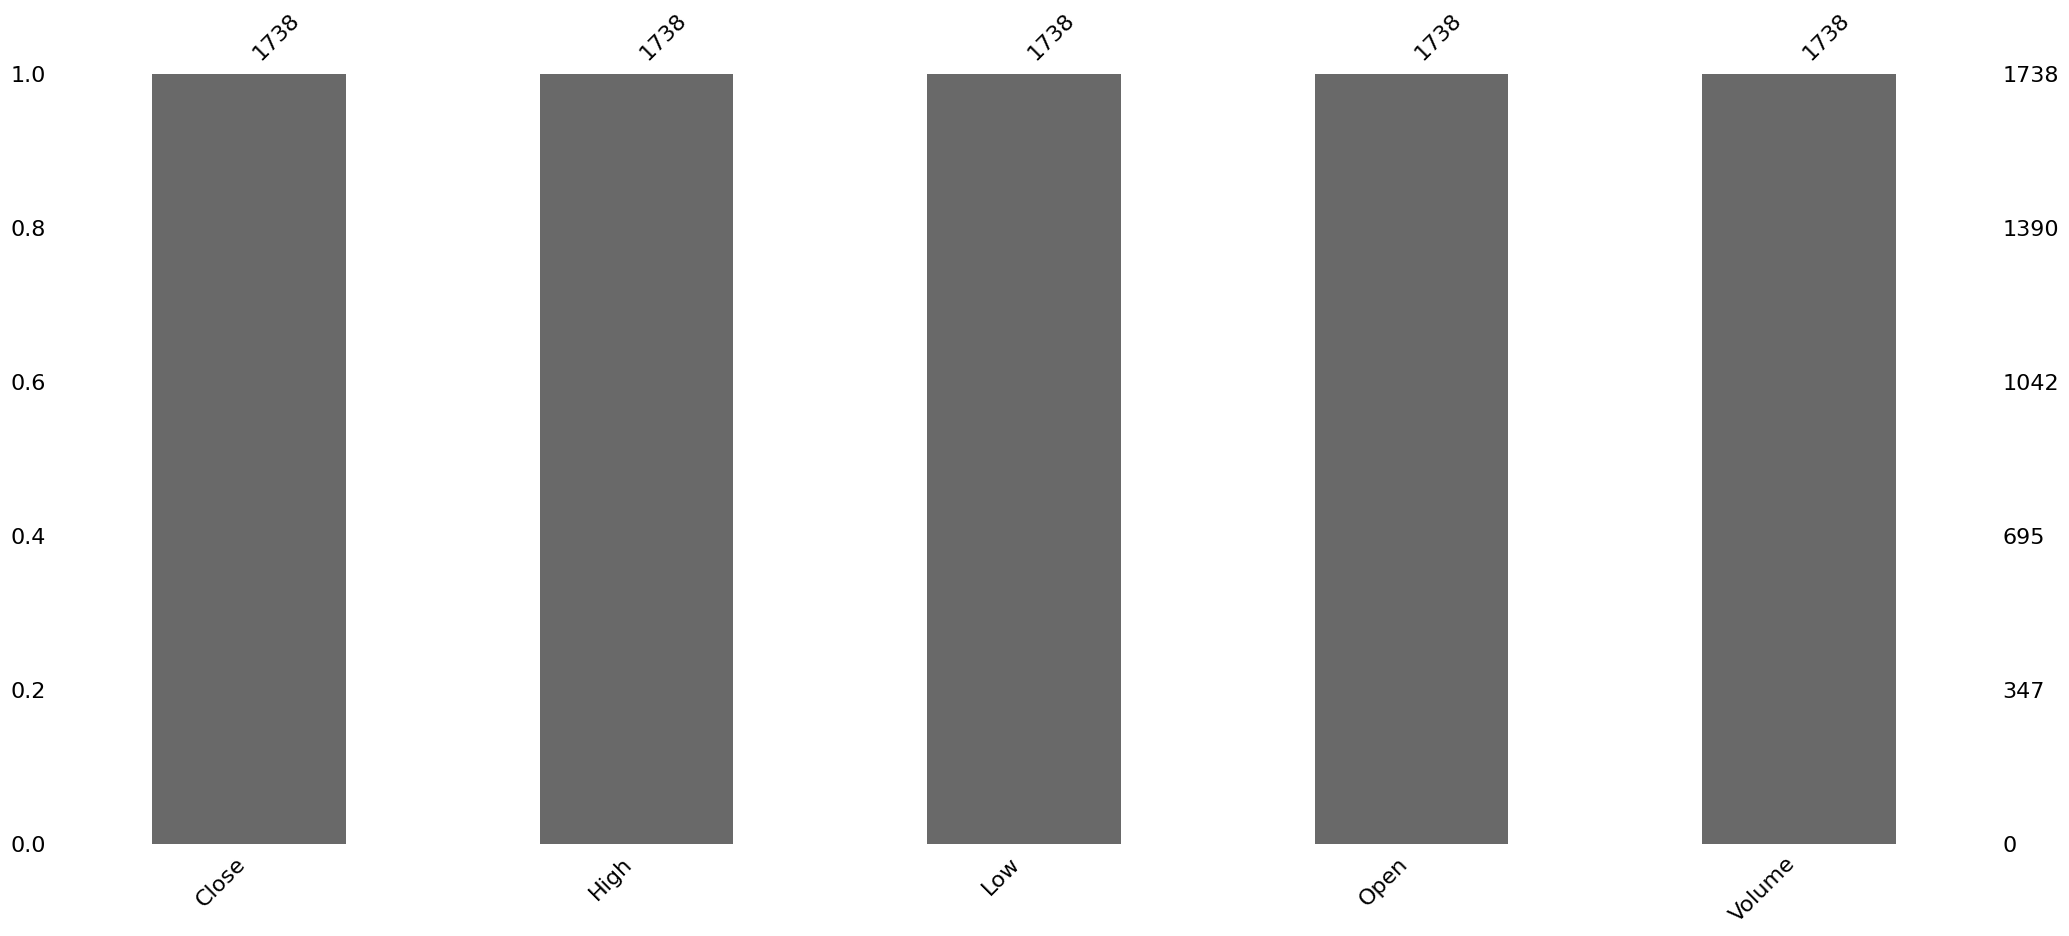

In [24]:
# Gráfico de barras de valores faltantes
msno.bar(data_btc_simplificado)
plt.show()

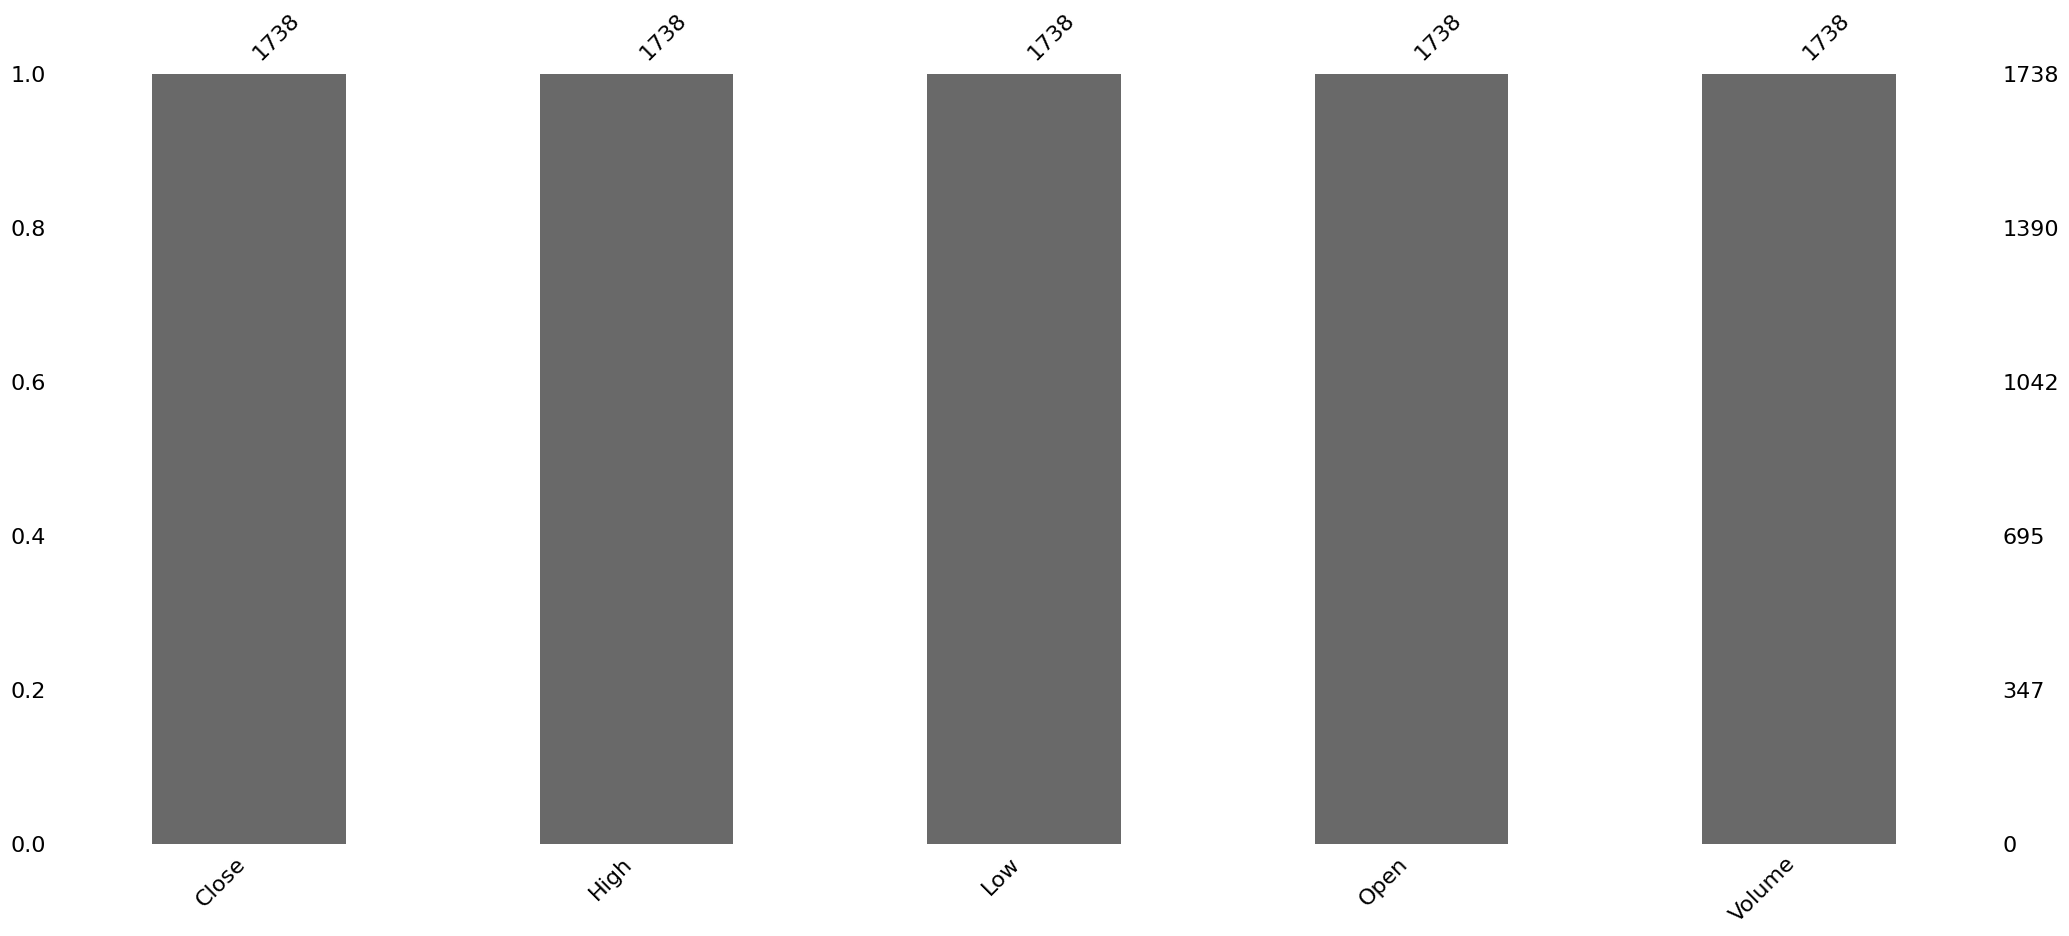

In [25]:
# Gráfico de barras de valores faltantes
msno.bar(data_oro_simplificado)
plt.show()

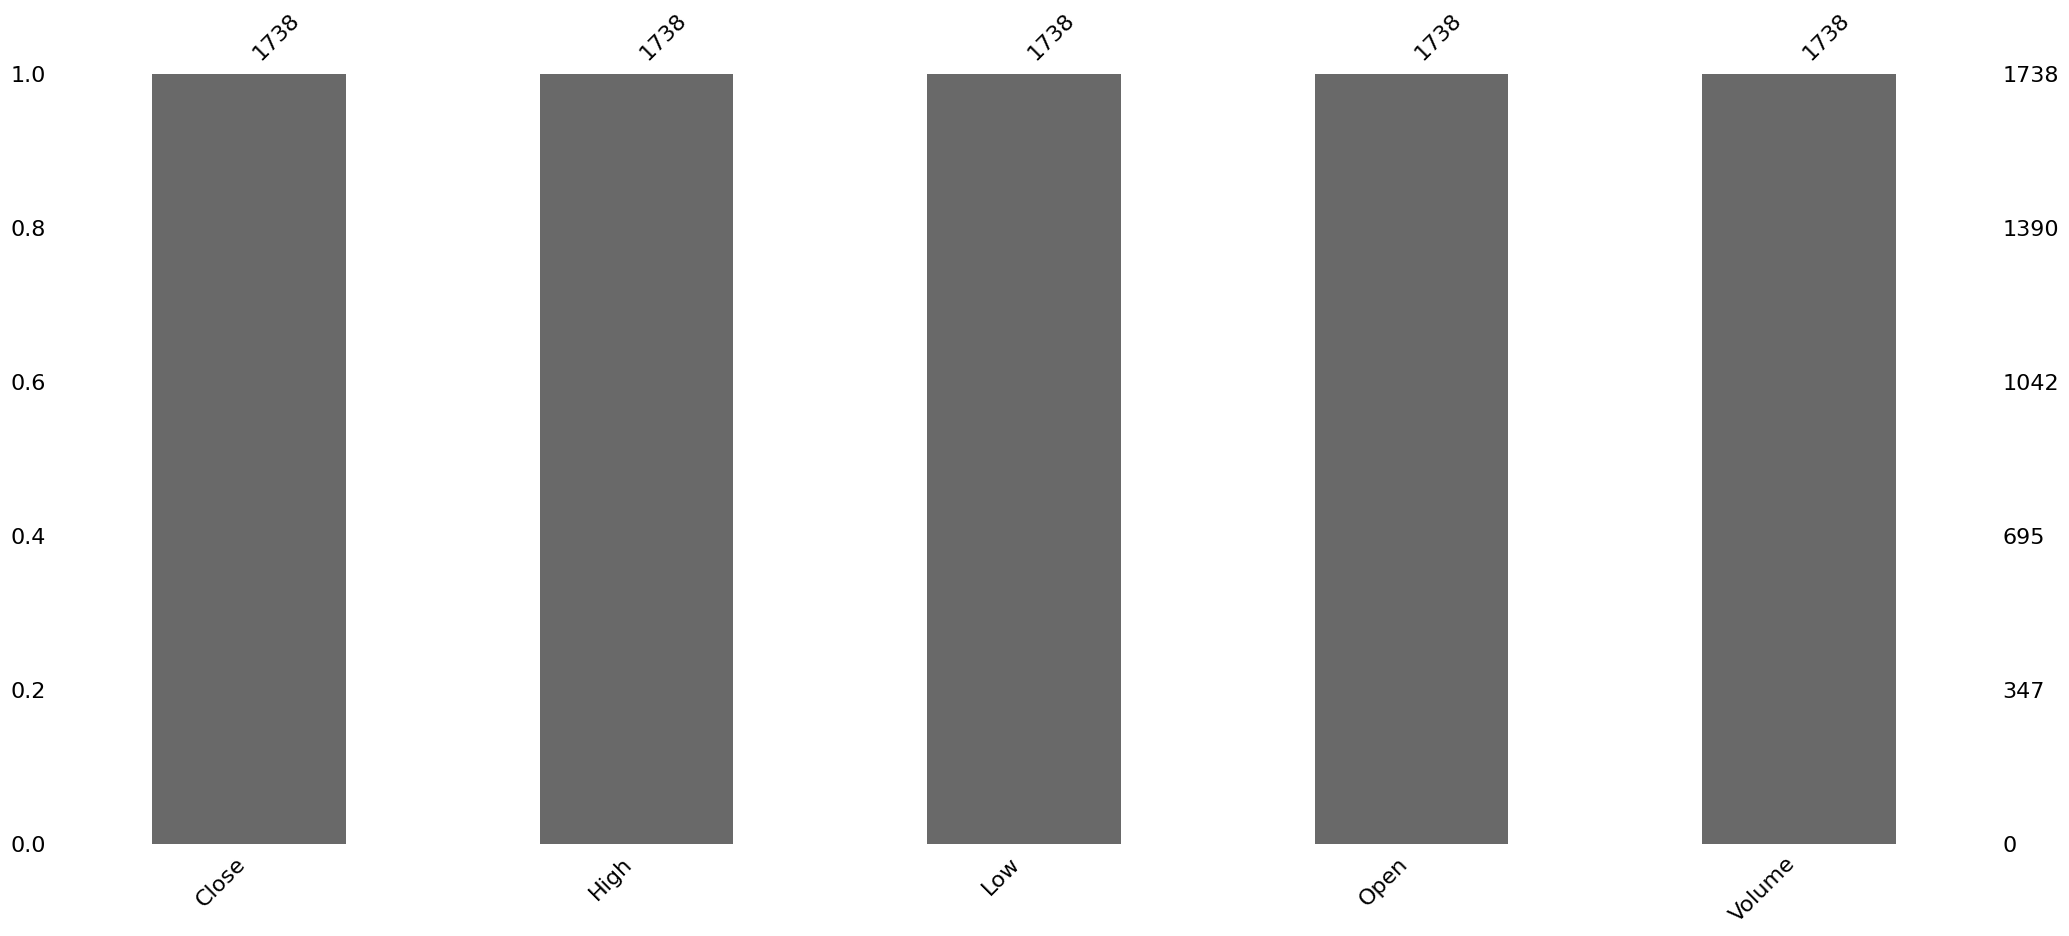

In [26]:
# Gráfico de barras de valores faltantes
msno.bar(data_eur_simplificado)
plt.show()

### Se observa ahora la variación anual en % de cada valor

In [27]:
# 1. Seleccionar solo la columna 'Close' de cada DataFrame
data_btc = data_btc_simplificado[['Close']]
data_oro = data_oro_simplificado[['Close']]
data_eur = data_eur_simplificado[['Close']]

# 2. Calcular variaciones anuales para BTC
btc_anual = data_btc_simplificado['Close'].resample('YE').last()  # Último precio de cada año
variacion_btc = btc_anual.pct_change() * 100        # Variación porcentual

# 3. Calcular variaciones anuales para Oro
oro_anual = data_oro_simplificado['Close'].resample('YE').last()
variacion_oro = oro_anual.pct_change() * 100

# 4. Calcular variaciones anuales para EUR
eur_anual = data_eur_simplificado['Close'].resample('YE').last()
variacion_eur = eur_anual.pct_change() * 100

# 5. Combinar resultados en un DataFrame
df_variaciones = pd.DataFrame({
    'BTC (%)': variacion_btc,
    'Oro (%)': variacion_oro,
    'EUR (%)': variacion_eur
}).dropna()  # Eliminar filas con NaN

# 6. Mostrar resultados con formato
df_variaciones.index = df_variaciones.index.year
display(df_variaciones.style.format('{:.2f}%'))

,BTC (%),Oro (%),EUR (%)
Date,,,
2019,92.20%,18.87%,-2.08%
2020,303.16%,24.59%,9.80%
2021,59.67%,-3.47%,-7.93%
2022,-64.15%,-0.43%,-5.87%
2023,153.57%,13.34%,3.82%
2024,121.93%,27.48%,-5.98%


### Asignamos valores numéricos a las columna **'value_classification'** de 'data_fear_greed'

In [28]:
print(data_fear_greed['value_classification'].unique())

# Crear un diccionario de mapeo
mapeo = {
    'Extreme Fear': 0,
    'Fear': 1,
    'Neutral': 2,
    'Greed': 3,
    'Extreme Greed': 4
}

# Aplicarlo a la columna
data_fear_greed['value_classification'] = data_fear_greed['value_classification'].map(mapeo)

print(data_fear_greed)


['Fear' 'Extreme Fear' 'Greed' 'Neutral' 'Extreme Greed']
            FearGreedIndex  value_classification time_until_update
Date                                                              
2018-02-01              30                     1               NaN
2018-02-02              15                     0               NaN
2018-02-05              11                     0               NaN
2018-02-06               8                     0               NaN
2018-02-07              36                     1               NaN
...                    ...                   ...               ...
2024-12-24              73                     3               NaN
2024-12-26              79                     4               NaN
2024-12-27              74                     3               NaN
2024-12-30              65                     3               NaN
2024-12-31              64                     3               NaN

[1738 rows x 3 columns]


### Se unen las columnas necesarias para el entrenamiento en un solo dataframe
>- 'data_btc_simplificado', 'data_oro_simplificado', 'data_eur_simplificado', 'data_vix_simplificado': columna **'Close'**
>- 'data_fed_rate': columna **'FedRate'**
>- 'data_google_trends': columna **'Bitcoin'**
>- 'data_fear_greed': columna **'value_classification'**

In [29]:
# Extraer columnas específicas y renombrarlas
df1_cols = data_btc_simplificado[['Close']].rename(columns={'Close': 'Close_BTC'})
df2_cols = data_oro_simplificado[['Close']].rename(columns={'Close': 'Close_ORO'})
df3_cols = data_eur_simplificado[['Close']].rename(columns={'Close': 'Close_EUR'})
df4_cols = data_vix_simplificado[['Close']].rename(columns={'Close': 'Close_VIX'})
df5_cols = data_fed_rate[['FedRate']]
df6_cols = data_google_trends[['Bitcoin']].rename(columns={'Bitcoin': 'Google_Trends'})
df7_cols = data_fear_greed[['value_classification']].rename(columns={'value_classification': 'Fear_Greed'})

# Ahora unir
nuevo_df = pd.concat([df1_cols, df2_cols, df3_cols, df4_cols, df5_cols, df6_cols, df7_cols], axis=1)

display(nuevo_df.head().style.format('{:.2f}'))

,Close_BTC,Close_ORO,Close_EUR,Close_VIX,FedRate,Google_Trends,Fear_Greed
Date,,,,,,,
2018-02-01 00:00:00,9170.54,1344.30,1.24,13.47,1.42,27.00,1.00
2018-02-02 00:00:00,8830.75,1333.70,1.25,17.31,1.42,36.00,0.00
2018-02-05 00:00:00,6955.27,1333.00,1.24,37.32,1.42,35.00,0.00
2018-02-06 00:00:00,7754.00,1326.10,1.24,29.98,1.42,46.00,0.00
2018-02-07 00:00:00,7621.30,1311.60,1.24,27.73,1.42,28.00,1.00


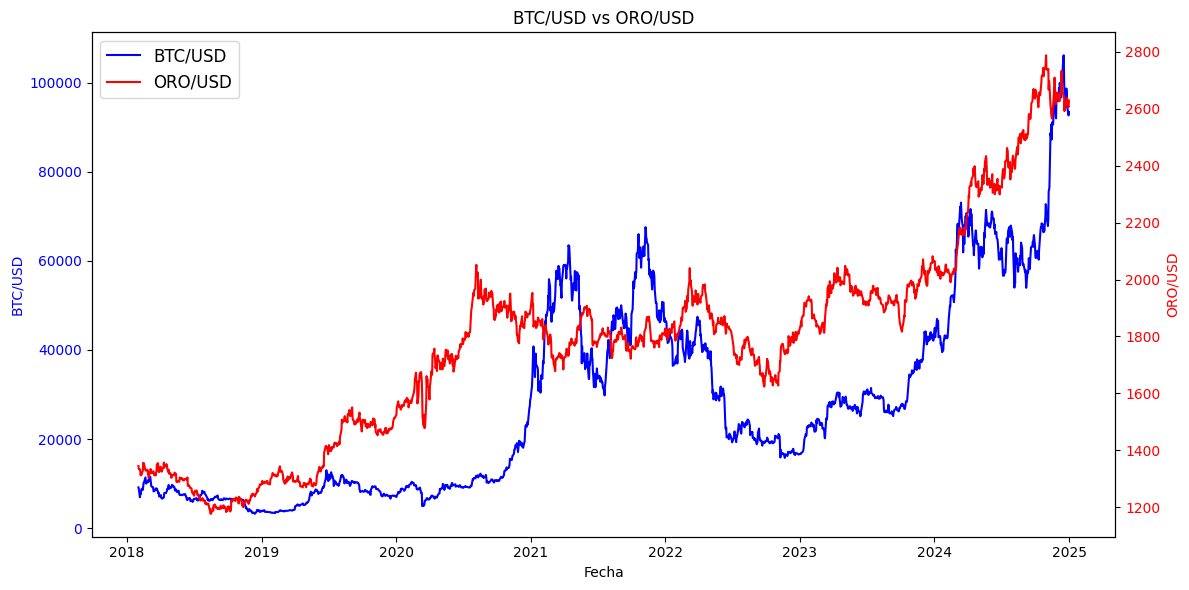

In [30]:
# "BTC/USD vs ORO/USD"

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_title("BTC/USD vs ORO/USD")
ax1.set_xlabel("Fecha")
ax1.set_ylabel("BTC/USD", color='blue')
line1, = ax1.plot(nuevo_df.index, nuevo_df['Close_BTC'], color='blue', label="BTC/USD")
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel("ORO/USD", color='red')
line2, = ax2.plot(nuevo_df.index, nuevo_df['Close_ORO'], color='red', label="ORO/USD")
ax2.tick_params(axis='y', labelcolor='red')

# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, fontsize=12)

plt.tight_layout()
plt.show()

# Guardar CSV para análisis
df.to_csv("btc_fed_data.csv")

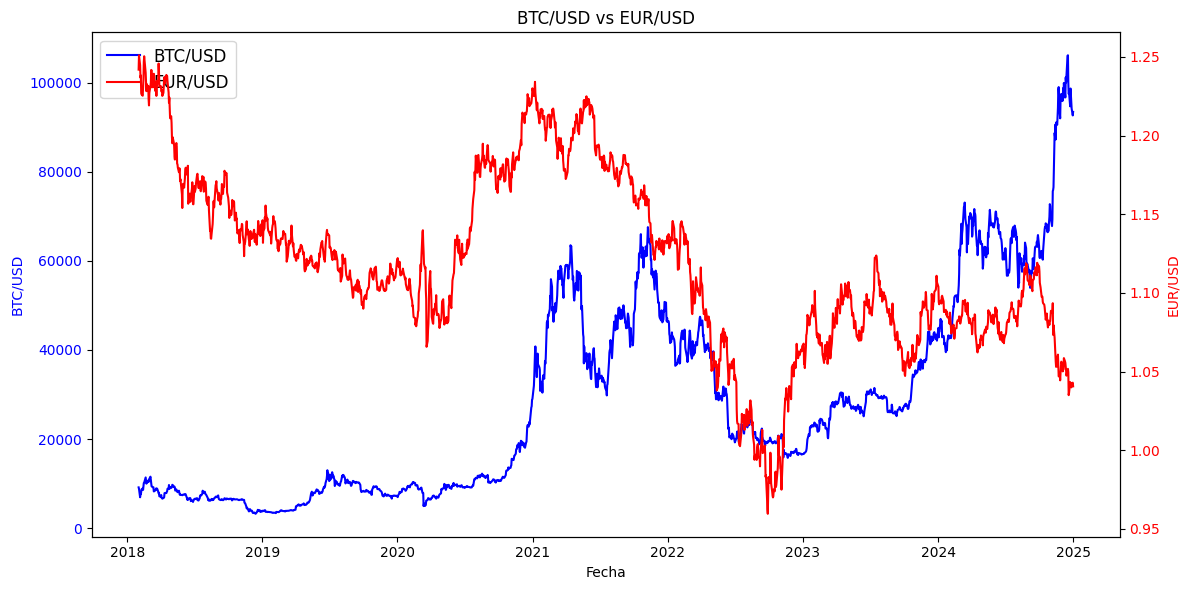

In [31]:
# "BTC/USD vs EUR/USD"

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_title("BTC/USD vs EUR/USD")
ax1.set_xlabel("Fecha")
ax1.set_ylabel("BTC/USD", color='blue')
line1, = ax1.plot(nuevo_df.index, nuevo_df['Close_BTC'], color='blue', label="BTC/USD")
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel("EUR/USD", color='red')
line2, = ax2.plot(nuevo_df.index, nuevo_df['Close_EUR'], color='red', label="EUR/USD")
ax2.tick_params(axis='y', labelcolor='red')

# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, fontsize=12)
plt.tight_layout()
plt.show()

# Guardar CSV para análisis
df.to_csv("btc_eur.csv")

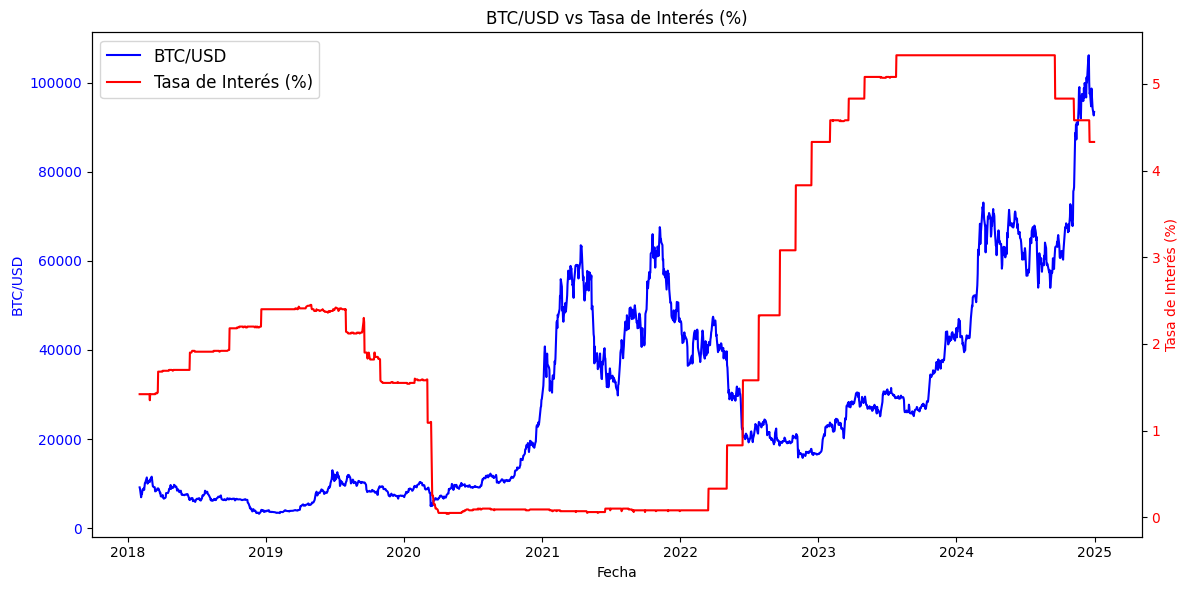

In [32]:
# BTC/USD vs Tasa de Interés de la Reserva Federal

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_title("BTC/USD vs Tasa de Interés (%)")
ax1.set_xlabel("Fecha")
ax1.set_ylabel("BTC/USD", color='blue')
line1, = ax1.plot(nuevo_df.index, nuevo_df['Close_BTC'], color='blue', label="BTC/USD")
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel("Tasa de Interés (%)", color='red')
line2, = ax2.plot(nuevo_df.index, nuevo_df['FedRate'], color='red', label="Tasa de Interés (%)")
ax2.tick_params(axis='y', labelcolor='red')

# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, fontsize=12)

plt.tight_layout()
plt.show()

# Guardar CSV para análisis
df.to_csv("btc_fed_data.csv")

## Propuesta de arquitectura de red neuronal

### Clasificación: ¿Sube o baja?

In [33]:

# Asegurar que está en orden cronológico
nuevo_df_clasif = nuevo_df.copy()
nuevo_df_clasif = nuevo_df_clasif.sort_index()  

# Crear la columna objetivo: si el precio del día siguiente es mayor al de hoy
nuevo_df_clasif['target'] = (nuevo_df_clasif['Close_BTC'].shift(-1) > nuevo_df_clasif['Close_BTC']).astype(int)

# Eliminar la última fila (porque no tiene precio del día siguiente para comparar)
nuevo_df_clasif = nuevo_df_clasif[:-1]

# Separar features y target
X = nuevo_df_clasif.drop(columns=['target'])  # Entradas
y = nuevo_df_clasif['target']                 # Salida

# Separar 80% entrenamiento, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False 
)

print("Entrenamiento:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)


Entrenamiento: (1389, 7) (1389,)
Test: (348, 7) (348,)


Este modelo predice probabilidades de subida. 

Para tareas como:
Métricas: accuracy, precision, recall, f1_score.

#### LEAKYRELU

Menor riesgo de sobreajuste con menos capas y neuronas.

LeakyReLU ayuda a evitar el problema de las "neuronas muertas", lo cual es útil cuando hay menos datos.

Rapidez en el entrenamiento. No se necesita tantas épocas para entrenar el modelo y aún así debería generalizar bien.

In [34]:
# Escalar datos
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear el modelo
model = Sequential([
    Dense(32, input_shape=(X_train_scaled.shape[1],)),
    LeakyReLU(alpha=0.1),
    Dense(16),
    LeakyReLU(alpha=0.1),
    Dense(1, activation='sigmoid')
])
model.summary()

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar
early_stop = EarlyStopping(
    monitor='val_loss',       # Lo que se observa para detener (también puede ser 'val_accuracy')
    patience=5,               # Cuántas épocas esperar sin mejora
    restore_best_weights=True # Recupera los mejores pesos
)

history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stop]   # Aquí se usa
)


C:\Users\jorge\anaconda3\envs\TFE\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\jorge\anaconda3\envs\TFE\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 801 (3.13 KB)

 Trainable params: 801 (3.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4849 - loss: 0.6974 - val_accuracy: 0.4828 - val_loss: 0.6954
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5203 - loss: 0.6929 - val_accuracy: 0.4828 - val_loss: 0.6960
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5173 - loss: 0.6921 - val_accuracy: 0.4828 - val_loss: 0.6986
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5303 - loss: 0.6915 - val_accuracy: 0.4828 - val_loss: 0.6960
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5365 - loss: 0.6911 - val_accuracy: 0.5086 - val_loss: 0.6934
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5250 - loss: 0.6892 - val_accuracy: 0.4885 - val_loss: 0.6964
Epoch 7/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4934 - loss: 0.6910 - val_accuracy: 0.4828 - val_loss: 0.6999
Epoch 8/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5119 - loss: 0.6877 - val_accuracy: 0.

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5201 - loss: 0.6933 

Pérdida en test: 0.6934
Precisión en test: 0.5086



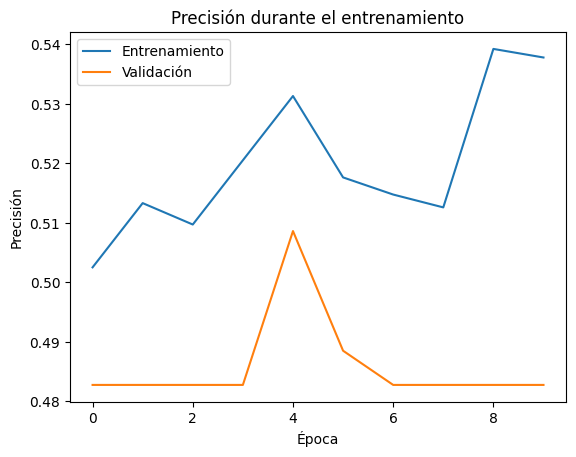

In [35]:
# Evaluar en el conjunto de test
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"\nPérdida en test: {loss:.4f}")
print(f"Precisión en test: {accuracy:.4f}\n")

plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()

#### RELU

Este modelo es más profundo y puede ser útil si el problema es lo suficientemente
complejo y los datos contienen patrones difíciles de aprender.

In [36]:

# Escalar datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear el modelo
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # 1 salida entre 0 y 1
])
model.summary()

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar
early_stop = EarlyStopping(
    monitor='val_loss',       # Lo que se observa para detener (también puede ser 'val_accuracy')
    patience=5,               # Cuántas épocas esperar sin mejora
    restore_best_weights=True # Recupera los mejores pesos
)

history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stop]   # Aquí se usa
)


C:\Users\jorge\anaconda3\envs\TFE\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,897 (34.75 KB)

 Trainable params: 8,897 (34.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4942 - loss: 0.6956 - val_accuracy: 0.4770 - val_loss: 0.6980
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5676 - loss: 0.6868 - val_accuracy: 0.5115 - val_loss: 0.6946
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5507 - loss: 0.6813 - val_accuracy: 0.4828 - val_loss: 0.7070
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5828 - loss: 0.6772 - val_accuracy: 0.4655 - val_loss: 0.6980
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5789 - loss: 0.6774 - val_accuracy: 0.5144 - val_loss: 0.6935
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5643 - loss: 0.6749 - val_accuracy: 0.4885 - val_loss: 0.7119
Epoch 7/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5661 - loss: 0.6809 - val_accuracy: 0.4770 - val_loss: 0.7012
Epoch 8/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5978 - loss: 0.6691 - val_accuracy: 0.

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5025 - loss: 0.6949 

Pérdida en test: 0.6935
Precisión en test: 0.5144



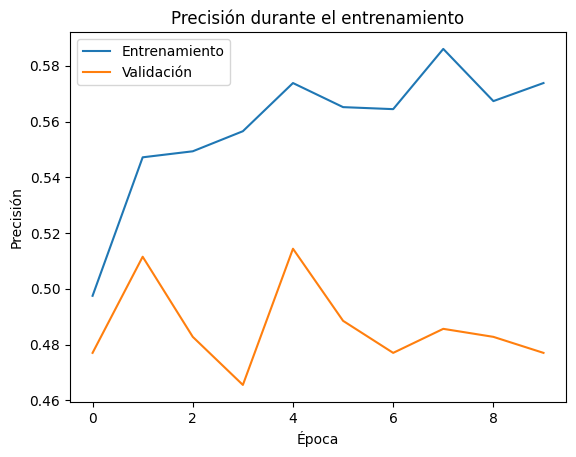

In [37]:
# Evaluar en el conjunto de test
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"\nPérdida en test: {loss:.4f}")
print(f"Precisión en test: {accuracy:.4f}\n")

plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()

Posible problema y qué significa
>- Variables poco informativas:	los inputs (X) no tienen suficiente información para predecir si BTC sube o baja.
>- Poca cantidad de datos: si tienes muy pocas filas, la red neuronal no puede aprender patrones.
>- Relación muy débil o inexistente: no hay realmente un patrón fuerte en tus indicadores actuales que permita predecir BTC a corto plazo.
>- Ruido y volatilidad natural: el precio de BTC es muy volátil. A veces no depende de tendencias simples, sino de eventos externos impredecibles.
>- Target demasiado difícil: predecir subida/bajada de un día para otro es muy difícil, incluso para modelos profesionales.

Se decide continuar con la regresión pero obteniendo el precio del BTC en horas, para aumentar la cantidad de filas para el entrenamiento del modelo.